![NYPLogo.png](attachment:NYPLogo.png)

# IT3311 Assignment - Task 1: Text Classification

You are required to build a text classification model to predict the product category based on the product name and description.

**Tasks:**

1. **Data Understanding**: Examine the dataset
2. **Data Preparation**: Prepares the data and all necessary preprocessing tasks
3. **Modelling**: Use different text representation and algorithms
4. **Evaluation**: Evaluates results from the algorithms and select the best model

**Done by: Chua ZhengHong Jonathan - 201611S**

# Table of contents
1. [Data Understanding](#understanding)
    * 1.1 [Item Name](#understandingcategory)
    * 1.2 [Description](#understandingdescription)
2. [Data Preparation](#preparation)
    * 2.1 [Remove Punctuation, Numbers and Stopwords then perform Stemming](#clean)
    * 2.2 [Common Word Removal](#removecommonwords)
3. [Modelling](#modelling)
    * 3.1 [Data Representations](#datarepresentation)
        * 3.1.1 [Generate Vector Space Model using TF-IDF](#tfidf)
    * 3.2 [Supervised Learning Classifiers](#supervised)
        * 3.2.1 [Logistic Regression](#logisticregression)
        * 3.2.2 [Support Vector Machine](#svc)
        * 3.2.3 [Naive Bayes](#naivebayes)
4. [Evaluation](#evaluation)
    * 4.1 [Multiclass Classification](#multiclass)
        * 4.1.1 [Predicting Category via Logistic Regression](#predictlogisticregression)
        * 4.1.2 [Predicting Category via Support Vector Machine](#predictsvc)
        * 4.1.3 [Predicting Category via Decision Tree](#predictnaivebayes)
    * 4.2 [Model selection, Performance Evaluation and Hyperparameter Tuning using Pipeline along with GridSearch](#gridsearchcv)
    * 4.3 [Performing Predictions](#prediction)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Text and Media Analytics/'

/content/drive/MyDrive/Text and Media Analytics


## Import libraries and download the packages

In [120]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 
%matplotlib inline
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
#Import Stopwords list
from nltk.corpus import stopwords

#Importing word tokenizer
from nltk.tokenize import word_tokenize

#Import frequency distribution
from nltk.probability import FreqDist

import string
nltk.download('omw-1.4')
#Import Wordnet Lemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

from glob import glob

from itertools import cycle

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Read the dataset

Read the csv file.

In [85]:
df = pd.read_csv('data.csv')

## Data Understanding
Perform the necessary steps and explain the rationale taken here.



In [6]:
df.head(5)

,item_id,item_name,image_name,description,category
0,1,etude house drawing eye brow ad,1.jpg,READY\n[Etude Eyebrow]\nnote : tuliskan di ket...,Eye
1,2,etude house drawing eyebrow,2.jpg,READY JGN TNYA LAGI YA \n\nKUALITAS BOLEH DI A...,Eye
2,3,etude -new drawing eyebrow,3.jpg,Barang ORI ya..\nHarga jg sudah nett..\n\nOpti...,Eye
3,4,etude house drawing eye brow ad,4.jpg,QTY PM AJA YA :\nATC TIDAK ADA ALASAN APAPUN P...,Eye
4,5,etude house - color my brow,5.jpg,"ETUDE HOUSE - COLOR MY BROW\n\nTAHAN LAMA, ALI...",Eye


Head reveals that the description is not necessariliy in English. This means stopword removal needs to be done in another language.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887 entries, 0 to 1886
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   item_id      1887 non-null   int64 
 1   item_name    1887 non-null   object
 2   image_name   1887 non-null   object
 3   description  1887 non-null   object
 4   category     1887 non-null   object
dtypes: int64(1), object(4)
memory usage: 73.8+ KB


This dataset has 5 columns, item_id, item_name, image_name, description, category. There are 1887 documents and no column has null values.<br>
Excluding the item_id (likely the unique identifier and hence not a meaningful feature, all the columns are of String dtype (represented as object in DataFrame).<br>

In [8]:
df.isnull().sum()

item_id        0
item_name      0
image_name     0
description    0
category       0
dtype: int64

There are no missing values.

### 1.1 Data Understanding - Item Name<a name='understandingname'></a>

#### Tokenization

In [87]:
#Loop through all reviews and tokenize into words
df['item_name'] = df['item_name'].apply(lambda x: word_tokenize(x.lower()))
all_name_words = [word for sent in df['item_name'] for word in sent]

#print the first 10 words
print(all_name_words[:10])

['etude', 'house', 'drawing', 'eye', 'brow', 'ad', 'etude', 'house', 'drawing', 'eyebrow']


In [88]:
# calculate the number of occurence of each word in the entire list of words
all_name_words_frequency = FreqDist(all_name_words)
print (all_name_words_frequency)

# print 10 most frequently occurring words
print ("\nTop 10 most frequently occurring words")
print (all_name_words_frequency.most_common(10))

# print 10 least frequently occurring words
print ("\nTop 10 least frequently occurring words")
print (all_name_words_frequency.most_common()[-10:])

<FreqDist with 1274 samples and 14645 outcomes>

Top 10 most frequently occurring words
[('maybelline', 678), ('etude', 524), ('house', 409), ('bb', 350), ('powder', 303), ('cushion', 288), ('bioaqua', 284), ('-', 228), ('foundation', 228), ('matte', 221)]

Top 10 least frequently occurring words
[('pro-matte', 1), ('loreal', 1), ('50g', 1), ('expressã\x82â®', 1), ('shotã¢â\x84â¢', 1), ('washable', 1), ('pot', 1), ('violet', 1), ('qd04', 1), ('us', 1)]


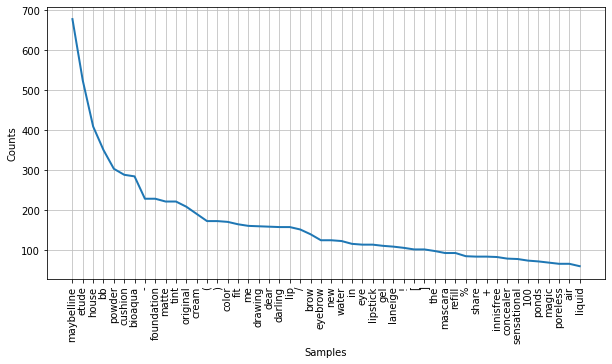

In [68]:
# create a function to plot the frequency, make it a function as we will be re-using it later.
def plot_frequency(freq):
    plt.figure(figsize=(10,5))
    freq.plot(50, cumulative=False)
    plt.show()

plot_frequency(all_name_words_frequency)

The top 3 most common words are maybelline, etude, house, which are brand names. These will be added to stop words later. Aside from punctuation, words like matte, foundation, and bb are meaninful to distinguish product category so these will be kept.

### 1.2 Data Understanding - Description <a name='understandingdescription'></a>

See the first 5 descriptions.

In [69]:
for i in range(5):
  print("-"*50)
  print("description of index number: "+str(i))
  display(df['description'][i])

--------------------------------------------------
description of index number: 0


'READY [Etude Eyebrow] note : tuliskan di keterangan warna item yang dipilih Pensil alis bertekstur lembut hadir dengan bermacam varian warna agar sesuai dengan warna kulit & rambut, memberikan hasil natural & rapi Drawing Eye Brow AD 01 dark brown Drawing Eye Brow AD 02 grey brown  Drawing Eye Brow AD 03 brown Drawing Eye Brow AD 04 dark grey  Drawing Eye Brow AD 05 grey Drawing Eye Brow AD 06 black apabila tdk tersedia dikirim yg ada , kecuali tdk ada = cancel no komplain !!!'

--------------------------------------------------
description of index number: 1


'READY JGN TNYA LAGI YA  KUALITAS BOLEH DI ADU DENGAN TOKO SEBELAH ^^ 01.DARK BROWN = READY 02.GRAY BROWN = READY 03. BROWN = READY 04.DARK GRAY = READY 05.GRAY = READY 06. BLACK = READY Order tanpa varian/yg diminta habis, akan dikirim stok yg ada, kecuali ada note; varian kosong = cancel Barang bersegel, tidak menerima retur/komplain utk isi produk'

--------------------------------------------------
description of index number: 2


'Barang ORI ya.. Harga jg sudah nett.. Option : 1. Dark brown 2. Gray brown 3. Brown 4. Dark grey 5. Grey 6. Black 7. Light Brown Versi baru dr Drawing eyebrow lama,lbh panjang isinya..warna sama.. Utk order,lihat di contact profile ya Serious buyer,serious order only NO HIT&RUN DEAL,NO CANCEL #etudeorimurah #etudejkt #drawingeyebrownew #drawingeyebrowmurah #pensilalisetude #eyebrowetude #etudeeyebrow #makeup #makeupalis #pensilalis'

--------------------------------------------------
description of index number: 3


'QTY PM AJA YA : ATC TIDAK ADA ALASAN APAPUN PEMBATALAN AKAN KIRIM RANDOM WARNANYA. KARENA AKAN MENGURANGI PRESENTASE TRANSAKSI KAMI.. MOHON PENGERTIANNYA [Etude Eyebrow] note : tuliskan di keterangan warna item yang dipilih Pensil alis bertekstur lembut hadir dengan bermacam varian warna agar sesuai dengan warna kulit & rambut, memberikan hasil natural & rapi Drawing Eye Brow AD 01 dark brown  Drawing Eye Brow AD 02 grey brown  Drawing Eye Brow AD 03 brown  Drawing Eye Brow AD 04 dark grey Drawing Eye Brow AD 05 grey  Drawing Eye Brow AD 06 black #ETUDE #ALIS #KOSMETIK'

--------------------------------------------------
description of index number: 4


'ETUDE HOUSE - COLOR MY BROW TAHAN LAMA, ALIS SPT DISULAM. READY : # 01 RICH BROWN  # 02 LIGHT BROWN # 03 RED BROWN # 04 NATURAL BROWN # 05 BLONDE BROWN'

Description contains newline characters which have to be removed first before I can tokenize.

In [89]:
def remove_newline(text):
    '''
    replace newline characters with space.
    '''
    return re.sub(r'[\n\r\t]+', ' ', text)

Remove newline characters in the first 5 descriptions to see the changes.

In [71]:
for i in range(5):
  print("-"*50)
  print("description of index number: "+str(i))
  display(remove_newline(df['description'][i]))

--------------------------------------------------
description of index number: 0


'READY [Etude Eyebrow] note : tuliskan di keterangan warna item yang dipilih Pensil alis bertekstur lembut hadir dengan bermacam varian warna agar sesuai dengan warna kulit & rambut, memberikan hasil natural & rapi Drawing Eye Brow AD 01 dark brown Drawing Eye Brow AD 02 grey brown  Drawing Eye Brow AD 03 brown Drawing Eye Brow AD 04 dark grey  Drawing Eye Brow AD 05 grey Drawing Eye Brow AD 06 black apabila tdk tersedia dikirim yg ada , kecuali tdk ada = cancel no komplain !!!'

--------------------------------------------------
description of index number: 1


'READY JGN TNYA LAGI YA  KUALITAS BOLEH DI ADU DENGAN TOKO SEBELAH ^^ 01.DARK BROWN = READY 02.GRAY BROWN = READY 03. BROWN = READY 04.DARK GRAY = READY 05.GRAY = READY 06. BLACK = READY Order tanpa varian/yg diminta habis, akan dikirim stok yg ada, kecuali ada note; varian kosong = cancel Barang bersegel, tidak menerima retur/komplain utk isi produk'

--------------------------------------------------
description of index number: 2


'Barang ORI ya.. Harga jg sudah nett.. Option : 1. Dark brown 2. Gray brown 3. Brown 4. Dark grey 5. Grey 6. Black 7. Light Brown Versi baru dr Drawing eyebrow lama,lbh panjang isinya..warna sama.. Utk order,lihat di contact profile ya Serious buyer,serious order only NO HIT&RUN DEAL,NO CANCEL #etudeorimurah #etudejkt #drawingeyebrownew #drawingeyebrowmurah #pensilalisetude #eyebrowetude #etudeeyebrow #makeup #makeupalis #pensilalis'

--------------------------------------------------
description of index number: 3


'QTY PM AJA YA : ATC TIDAK ADA ALASAN APAPUN PEMBATALAN AKAN KIRIM RANDOM WARNANYA. KARENA AKAN MENGURANGI PRESENTASE TRANSAKSI KAMI.. MOHON PENGERTIANNYA [Etude Eyebrow] note : tuliskan di keterangan warna item yang dipilih Pensil alis bertekstur lembut hadir dengan bermacam varian warna agar sesuai dengan warna kulit & rambut, memberikan hasil natural & rapi Drawing Eye Brow AD 01 dark brown  Drawing Eye Brow AD 02 grey brown  Drawing Eye Brow AD 03 brown  Drawing Eye Brow AD 04 dark grey Drawing Eye Brow AD 05 grey  Drawing Eye Brow AD 06 black #ETUDE #ALIS #KOSMETIK'

--------------------------------------------------
description of index number: 4


'ETUDE HOUSE - COLOR MY BROW TAHAN LAMA, ALIS SPT DISULAM. READY : # 01 RICH BROWN  # 02 LIGHT BROWN # 03 RED BROWN # 04 NATURAL BROWN # 05 BLONDE BROWN'

Apply row-wise to the whole column.

In [90]:
df['description'] = df['description'].apply(lambda x: remove_newline(x))  

The words in description appear to have a language that is not English. I will take a look at the list of stopwords found in nltk to see which language fits best.

In [91]:
print(stopwords.fileids())

['arabic', 'azerbaijani', 'basque', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


Looking at this available stopwords list, I decided the description fits indonesian the most. Hence I will be using this along with English (some words are also in English).

#### Tokenization

In [92]:
#Loop through all reviews and tokenize into words
df['description'] = df['description'].apply(lambda x: word_tokenize(x.lower()))
all_description_words = [word for sent in df['description'] for word in sent]

#print the first 10 words
print(all_description_words[:10])

['ready', '[', 'etude', 'eyebrow', ']', 'note', ':', 'tuliskan', 'di', 'keterangan']


In [93]:
# calculate the number of occurence of each word in the entire list of words
all_description_words_frequency = FreqDist(all_description_words)
print (all_description_words_frequency)

# print 10 most frequently occurring words
print ("\nTop 10 most frequently occurring words")
print (all_description_words_frequency.most_common(10))

# print 10 least frequently occurring words
print ("\nTop 10 least frequently occurring words")
print (all_description_words_frequency.most_common()[-10:])

<FreqDist with 11831 samples and 186595 outcomes>

Top 10 most frequently occurring words
[('#', 8631), ('.', 5786), (',', 5037), ('dan', 2801), (':', 2674), ('-', 2242), ('yang', 2065), (')', 1604), ('dengan', 1585), ('untuk', 1582)]

Top 10 least frequently occurring words
[('konfirm', 1), ('menyebutkan', 1), ('dicantumkan', 1), ('meringankan', 1), ('pulih', 1), ('ketidaknyamanan', 1), ('ã°â\x9fâ\x92â¡bisa', 1), ('ã°â\x9fâ\x92â¡cek', 1), ('ã°â\x9fâ\x92â¡info', 1), ('lipmoisturizer', 1)]


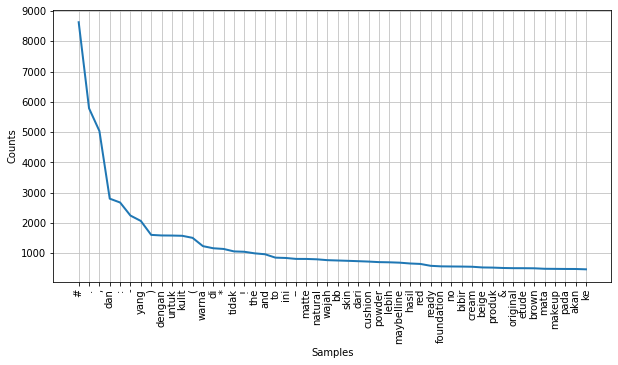

In [77]:
plot_frequency(all_description_words_frequency)

Description contains much muore samples and outcomes compared to the item name. Most frequently occuring words are mainly punctuation that have to be removed.

### 1.3 Data Understanding - Category<a name='understandingcategory'></a>

As a start I would like to know the possible list of categories. I can do so via getting the value_counts() of the Category column.

In [60]:
df['category'].value_counts()

Face    931
Lip     501
Eye     455
Name: category, dtype: int64

There are 3 unique values in categories, Face, Lip and Eye.

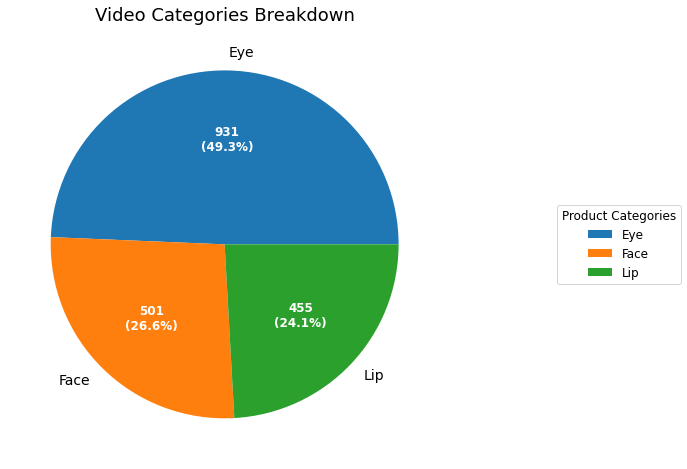

In [61]:
categories = df['category'].unique()
cat_counts = df['category'].value_counts()
pie_data = np.array(cat_counts)
zipped = zip(cat_counts,categories)

labels = [x for _,x in list(zipped)]
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw=dict(aspect="equal"))

def pie_text(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:d}\n({:.1f}%)".format(absolute, pct)

wedges, texts, autotexts = ax.pie(pie_data, labels=labels, autopct=lambda pct: pie_text(pct, pie_data),
                                  textprops=dict(color="w"))
for i in range(len(texts)):
    texts[i].set_color('k')
    texts[i].set_fontsize(14)

ax.legend(wedges, categories,
          title="Product Categories",
          loc="center left",
          bbox_to_anchor=(1.25, 0, 0.5, 1), fontsize=12)

plt.setp(autotexts, size=12, weight="bold")
plt.setp(plt.gca().get_legend().get_title(), fontsize='12')
ax.set_title("Video Categories Breakdown", fontsize=18)

plt.show() 

As seen in the pie chart above, there is a good mix of each video category and no unbalanced label. I will hence not apply techniques to handle unbalanced data.

## 2. Data Preparation
Perform the necessary steps and explain the rationale taken here.



#### 2.1 Remove Punctuation, Numbers and Stopwords then perform Stemming<a name='clean'></a>

Set Stopwords to use.

In [94]:
stop_words=set(stopwords.words("indonesian"))
stop_words.update(stopwords.words('english'))

Define the function that removes punctuation, numbers, and stopwords along with lemmatization (to preserve the base words).

In [95]:
def clean(doc):
  all_words_clean = []
  for word in doc:
      # remove stopwords and number
      if word not in stop_words:
          # remove punctuation
          punc_free = ''.join([ch for ch in word if ch not in string.punctuation])
          if len(punc_free)>=2 and not punc_free.isdigit():
              # stem word to root word
              all_words_clean.append(lem.lemmatize(punc_free,"v"))
  return all_words_clean

Item Name

In [96]:
#Create a new list of words by removing stopwords and punctuation from all_words
df['item_name'] = df['item_name'].apply(lambda x: clean(x)) 

all_name_words_clean = [word for sent in df['item_name'] for word in sent]

In [97]:
# calculate the number of occurence of each word in the entire list of words
all_name_words_frequency = FreqDist(all_name_words_clean)
print (all_name_words_frequency)

# print 10 most frequently occurring words
print ("\nTop 10 most frequently occurring words")
print (all_name_words_frequency.most_common(10))

# print 10 least frequently occurring words
print ("\nTop 10 least frequently occurring words")
print (all_name_words_frequency.most_common()[-10:])

<FreqDist with 1045 samples and 12149 outcomes>

Top 10 most frequently occurring words
[('maybelline', 678), ('etude', 525), ('house', 415), ('bb', 355), ('powder', 304), ('cushion', 290), ('bioaqua', 285), ('matte', 269), ('foundation', 228), ('tint', 223)]

Top 10 least frequently occurring words
[('promatte', 1), ('loreal', 1), ('50g', 1), ('expressã\x82â®', 1), ('shotã¢â\x84â¢', 1), ('washable', 1), ('pot', 1), ('violet', 1), ('qd04', 1), ('us', 1)]


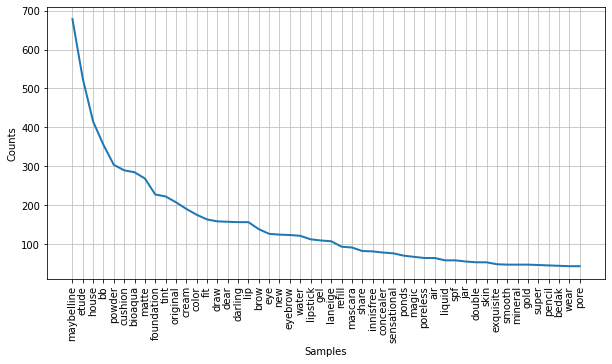

In [100]:
plot_frequency(all_name_words_frequency)

Description

In [98]:
#Create a new list of words by removing stopwords and punctuation from all_words
df['description'] = df['description'].apply(lambda x: clean(x)) 
all_description_words_clean =  [word for sent in df['description'] for word in sent]

In [99]:
# calculate the number of occurence of each word in the entire list of words
all_description_words_frequency = FreqDist(all_description_words_clean)
print (all_description_words_frequency)

# print 10 most frequently occurring words
print ("\nTop 10 most frequently occurring words")
print (all_description_words_frequency.most_common(10))

# print 10 least frequently occurring words
print ("\nTop 10 least frequently occurring words")
print (all_description_words_frequency.most_common()[-10:])

<FreqDist with 9988 samples and 105615 outcomes>

Top 10 most frequently occurring words
[('kulit', 1579), ('warna', 1234), ('matte', 857), ('natural', 808), ('wajah', 770), ('bb', 769), ('skin', 752), ('cushion', 722), ('powder', 706), ('maybelline', 686)]

Top 10 least frequently occurring words
[('ã°â\x9fâ\x94â\x8ecek', 1), ('konfirm', 1), ('dicantumkan', 1), ('meringankan', 1), ('pulih', 1), ('ketidaknyamanan', 1), ('ã°â\x9fâ\x92â¡bisa', 1), ('ã°â\x9fâ\x92â¡cek', 1), ('ã°â\x9fâ\x92â¡info', 1), ('lipmoisturizer', 1)]


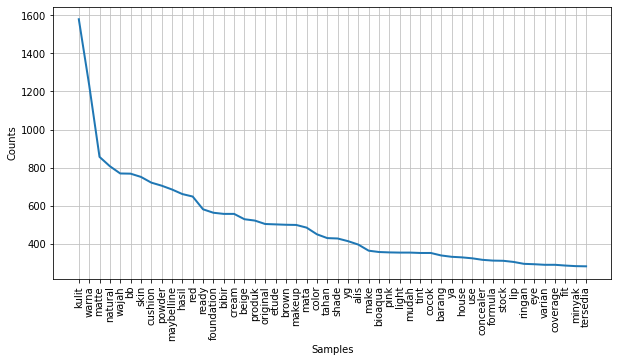

In [101]:
plot_frequency(all_description_words_frequency)

### 2.2 Common Word Removal<a name='removecommonwords'></a>

In [102]:
#add common words to stop words
common_words =['maybelline', 'etude', 'house', 'kulit', 'warna']
stop_words.update(common_words)

In [103]:
#Create a new list of words by removing stopwords and punctuation from all_words
df['item_name'] = df['item_name'].apply(lambda x: clean(x)) 

all_name_words_clean = [word for sent in df['item_name'] for word in sent]

In [104]:
# calculate the number of occurence of each word in the entire list of words
all_name_words_frequency = FreqDist(all_name_words_clean)
print (all_name_words_frequency)

# print 10 most frequently occurring words
print ("\nTop 10 most frequently occurring words")
print (all_name_words_frequency.most_common(10))

# print 10 least frequently occurring words
print ("\nTop 10 least frequently occurring words")
print (all_name_words_frequency.most_common()[-10:])

<FreqDist with 1039 samples and 10522 outcomes>

Top 10 most frequently occurring words
[('bb', 355), ('powder', 304), ('cushion', 290), ('bioaqua', 285), ('matte', 269), ('foundation', 228), ('tint', 223), ('original', 208), ('cream', 191), ('color', 176)]

Top 10 least frequently occurring words
[('promatte', 1), ('loreal', 1), ('50g', 1), ('expressã\x82â®', 1), ('shotã¢â\x84â¢', 1), ('washable', 1), ('pot', 1), ('violet', 1), ('qd04', 1), ('us', 1)]


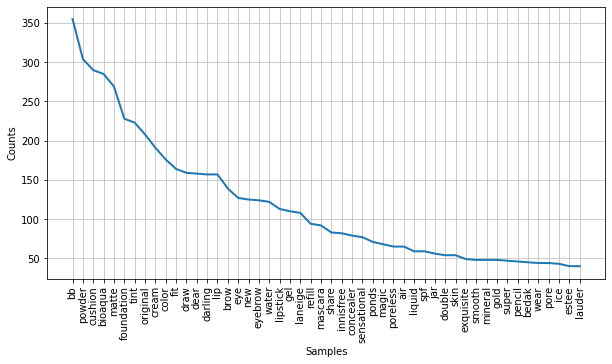

In [105]:
plot_frequency(all_name_words_frequency)

Description

In [106]:
#Create a new list of words by removing stopwords and punctuation from all_words
df['description'] = df['description'].apply(lambda x: clean(x)) 
all_description_words_clean =  [word for sent in df['description'] for word in sent]

In [107]:
# calculate the number of occurence of each word in the entire list of words
all_description_words_frequency = FreqDist(all_description_words_clean)
print (all_description_words_frequency)

# print 10 most frequently occurring words
print ("\nTop 10 most frequently occurring words")
print (all_description_words_frequency.most_common(10))

# print 10 least frequently occurring words
print ("\nTop 10 least frequently occurring words")
print (all_description_words_frequency.most_common()[-10:])

<FreqDist with 9951 samples and 101208 outcomes>

Top 10 most frequently occurring words
[('matte', 857), ('natural', 808), ('wajah', 770), ('bb', 769), ('skin', 752), ('cushion', 722), ('powder', 706), ('hasil', 662), ('red', 649), ('ready', 582)]

Top 10 least frequently occurring words
[('ã°â\x9fâ\x94â\x8ecek', 1), ('konfirm', 1), ('dicantumkan', 1), ('meringankan', 1), ('pulih', 1), ('ketidaknyamanan', 1), ('ã°â\x9fâ\x92â¡bisa', 1), ('ã°â\x9fâ\x92â¡cek', 1), ('ã°â\x9fâ\x92â¡info', 1), ('lipmoisturizer', 1)]


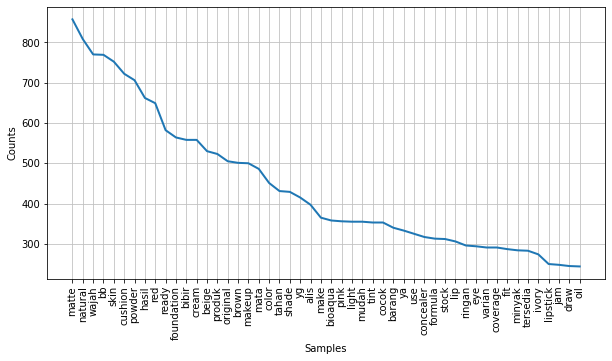

In [108]:
plot_frequency(all_description_words_frequency)

## 3. Modelling<a name='modelling'></a> 
Perform the necessary steps and explain the rationale taken here.



### 3.1 Data Representations<a name='datarepresentation'></a>

#### 3.1.1 Generate Vector Space Model using TF-IDF<a name='tfidf'></a>

In [110]:
df['Processed_item_name'] = df['item_name'].apply(lambda x: " ".join(x))  
df['Processed_description'] = df['description'].apply(lambda x: " ".join(x))  

In [111]:
df.head()

,item_id,item_name,image_name,description,category,Processed_item_name,Processed_description
0,1,"[draw, eye, brow, ad]",1.jpg,"[ready, eyebrow, note, tuliskan, keterangan, i...",Eye,draw eye brow ad,ready eyebrow note tuliskan keterangan item di...
1,2,"[draw, eyebrow]",2.jpg,"[ready, jgn, tnya, ya, kualitas, adu, toko, se...",Eye,draw eyebrow,ready jgn tnya ya kualitas adu toko sebelah 01...
2,3,"[new, draw, eyebrow]",3.jpg,"[barang, ori, ya, harga, jg, nett, option, dar...",Eye,new draw eyebrow,barang ori ya harga jg nett option dark brown ...
3,4,"[draw, eye, brow, ad]",4.jpg,"[qty, pm, aja, ya, atc, alasan, apapun, pembat...",Eye,draw eye brow ad,qty pm aja ya atc alasan apapun pembatalan kir...
4,5,"[color, brow]",5.jpg,"[color, brow, tahan, alis, spt, disulam, ready...",Eye,color brow,color brow tahan alis spt disulam ready rich b...


Item name

In [125]:
vectorizer_item_name = TfidfVectorizer(min_df = 1, stop_words = stop_words)
dtm_item_name = vectorizer_item_name.fit_transform(df['Processed_item_name'])

tfidf_name_features = pd.DataFrame(dtm_item_name.toarray(),index=df.index,columns=vectorizer_item_name.get_feature_names())
print(len(vectorizer_item_name.get_feature_names()))
tfidf_name_features.head()

1023


/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


,008gr,025g,025gr,03g,10gr,10ml,12gr,12pcs,12th,14g,...,wrap,wrna,wyatt,xu,ya,yellow,york,yuenai,zero,â¹
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Description

In [126]:
vectorizer_description = TfidfVectorizer(min_df = 1, stop_words = stop_words)
dtm_description = vectorizer_description.fit_transform(df['Processed_description'])

tfidf_description_features = pd.DataFrame(dtm_description.toarray(),index=df.index,columns=vectorizer_description.get_feature_names())
print(len(vectorizer_description.get_feature_names()))
tfidf_description_features.head()

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


9475


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,001mm,005mm,008gr,01dark,01dontã,01fresh,01honey,01natural,01oh,020beige,...,âºprodul,âºã,â¼,â¼eyeshadow,â¼originalã,â¼â,â¼ã,â½,â½ã,ãªâ¹â
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.194863,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.2 Supervised Learning Classifiers<a name='supervised'></a> 

I decided to try out various supervised learning classifiers because the images have been given labels (the categories). All of the following classifiers can be applied to multiclass classification.

#### 3.2.1 Logistic Regression<a name='logisticregression'></a> 

In [141]:
lr = LogisticRegression(max_iter=5000, random_state=1, solver='lbfgs', multi_class='multinomial', n_jobs=-1)

Logistic Regression that has uses a logistic sigmoid function to predict a value score for binary classification. Scikit learn provides a version of the classifier for more than two classes via their multi_class option.

#### 3.2.2 Support Vector Machine<a name='svc'></a> 

In [144]:
svc = SVC(kernel='rbf')

Uses the concept of the kernel to adapt to the sparse yet high dimensions of the vector space model.

#### 3.2.3 Naive Bayes<a name='naivebayes'></a> 

In [146]:
nb = MultinomialNB()

Probablistic model that assumes all the words in doc are independent. Multinomial Naive Bayes can be applied to fractional TF-IDF features.

## 4. Evaluation
Perform the necessary steps and explain the rationale taken here.



### 4.1 Multi-class Classification<a name='multiclass'></a>

I will be doing multi-class classification. This means that the label will be predicted to be one of the given categories, which are Face, Eye, Lip.

In [155]:
X_description = tfidf_description_features
X_name = tfidf_name_features
y = df['category']

In [156]:
#Split into 80% Training, 20% Test
X_description_train, X_description_test, y_train, y_test = train_test_split(X_description, y, test_size=0.2, random_state=1, stratify=y)

In [164]:
#Split into 80% Training, 20% Test
X_name_train, X_name_test, y_train, y_test = train_test_split(X_name, y, test_size=0.2, random_state=1, stratify=y)

#### 4.1.1 Predicting Category via Logistic Regression<a name='predictlogisticregression'></a>

Item Name

In [165]:
%time lr.fit(X_name_train, y_train)

CPU times: user 24.2 ms, sys: 9.15 ms, total: 33.3 ms
Wall time: 738 ms


LogisticRegression(max_iter=5000, multi_class='multinomial', n_jobs=-1,
                   random_state=1)

In [166]:
y_pred = lr.predict(X_name_test)
print("classification report:")
print(classification_report(y_test, y_pred))

classification report:
              precision    recall  f1-score   support

         Eye       0.99      0.97      0.98        91
        Face       0.98      0.99      0.98       187
         Lip       0.99      0.99      0.99       100

    accuracy                           0.98       378
   macro avg       0.99      0.98      0.98       378
weighted avg       0.98      0.98      0.98       378



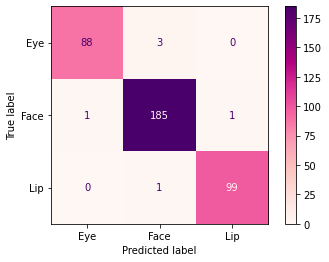

In [167]:
matrix = confusion_matrix(y_test, y_pred, labels = lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels= lr.classes_)
disp.plot(cmap='RdPu')

Description

In [157]:
%time lr.fit(X_description_train, y_train)

CPU times: user 176 ms, sys: 160 ms, total: 337 ms
Wall time: 6.38 s


LogisticRegression(max_iter=5000, multi_class='multinomial', n_jobs=-1,
                   random_state=1)

In [158]:
y_pred = lr.predict(X_description_test)
print("classification report:")
print(classification_report(y_test, y_pred))

classification report:
              precision    recall  f1-score   support

         Eye       0.96      0.87      0.91        91
        Face       0.89      0.99      0.94       187
         Lip       0.98      0.86      0.91       100

    accuracy                           0.93       378
   macro avg       0.94      0.91      0.92       378
weighted avg       0.93      0.93      0.93       378



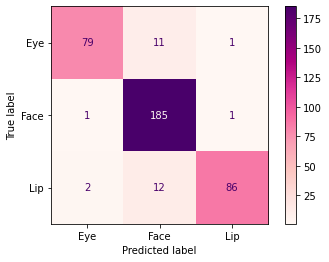

In [159]:
matrix = confusion_matrix(y_test, y_pred, labels = lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels= lr.classes_)
disp.plot(cmap='RdPu')

Item Name is a better indicator of the product category.

#### 4.1.2 Predicting Category via Support Vector Machine<a name='predictsvc'></a>

In [168]:
%time svc.fit(X_name_train, y_train)

CPU times: user 597 ms, sys: 1.32 ms, total: 598 ms
Wall time: 624 ms


SVC()

In [169]:
y_pred = svc.predict(X_name_test)
print("classification report:")
print(classification_report(y_test, y_pred))

classification report:
              precision    recall  f1-score   support

         Eye       0.99      0.96      0.97        91
        Face       0.97      0.99      0.98       187
         Lip       0.99      0.99      0.99       100

    accuracy                           0.98       378
   macro avg       0.98      0.98      0.98       378
weighted avg       0.98      0.98      0.98       378



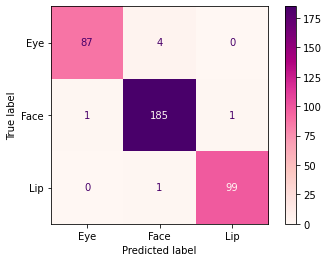

In [170]:
matrix = confusion_matrix(y_test, y_pred, labels = svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels= svc.classes_)
disp.plot(cmap='RdPu')

In [161]:
%time svc.fit(X_description_train, y_train)

CPU times: user 14.2 s, sys: 52.1 ms, total: 14.3 s
Wall time: 14.3 s


SVC()

In [162]:
y_pred = svc.predict(X_description_test)
print("classification report:")
print(classification_report(y_test, y_pred))

classification report:
              precision    recall  f1-score   support

         Eye       0.96      0.87      0.91        91
        Face       0.87      0.99      0.93       187
         Lip       0.99      0.83      0.90       100

    accuracy                           0.92       378
   macro avg       0.94      0.90      0.91       378
weighted avg       0.93      0.92      0.92       378



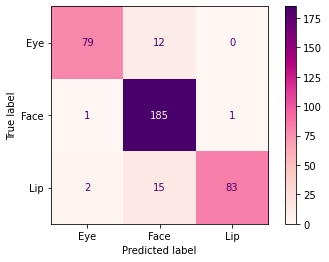

In [163]:
matrix = confusion_matrix(y_test, y_pred, labels = svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels= svc.classes_)
disp.plot(cmap='RdPu')

Lowered recall for Lip compared to using Logistic Regression.

#### 4.1.3 Predicting Category via Naive Bayes<a name='predictnaivebayes'></a>

In [171]:
%time nb.fit(X_name_train, y_train)

CPU times: user 29.8 ms, sys: 3.16 ms, total: 33 ms
Wall time: 30.3 ms


MultinomialNB()

In [172]:
y_pred = nb.predict(X_name_test)
print("classification report:")
print(classification_report(y_test, y_pred))

classification report:
              precision    recall  f1-score   support

         Eye       0.98      0.97      0.97        91
        Face       0.98      0.98      0.98       187
         Lip       0.97      0.98      0.98       100

    accuracy                           0.98       378
   macro avg       0.98      0.98      0.98       378
weighted avg       0.98      0.98      0.98       378



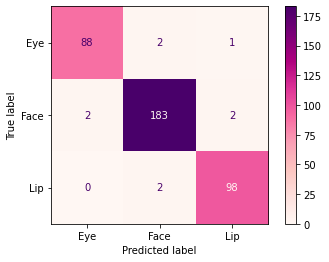

In [173]:
matrix = confusion_matrix(y_test, y_pred, labels = nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels= nb.classes_)
disp.plot(cmap='RdPu')

In [174]:
%time nb.fit(X_description_train, y_train)

CPU times: user 177 ms, sys: 10.9 ms, total: 188 ms
Wall time: 224 ms


MultinomialNB()

In [175]:
y_pred = nb.predict(X_description_test)
print("classification report:")
print(classification_report(y_test, y_pred))

classification report:
              precision    recall  f1-score   support

         Eye       0.96      0.88      0.92        91
        Face       0.88      0.99      0.93       187
         Lip       0.98      0.82      0.89       100

    accuracy                           0.92       378
   macro avg       0.94      0.90      0.91       378
weighted avg       0.92      0.92      0.92       378



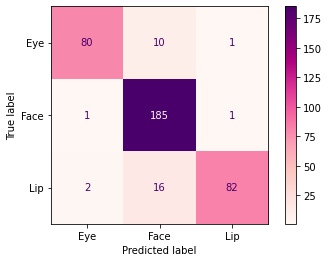

In [176]:
matrix = confusion_matrix(y_test, y_pred, labels = nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels= nb.classes_)
disp.plot(cmap='RdPu')

By far the lowest accuracy when using TF-TDF of description as compared to earlier classifiers.

### 4.2 Model selection, Performance Evaluation and Hyperparameter Tuning using Pipeline along with GridSearch<a name='gridsearchcv'></a>

From the previous results, it seems that Logistic Regression works better, applied to the TF-IDF item name vector space model so I will use this. Now I will attempt hyperparameter tuning to find the optimal hyperparamers for this model.

In [188]:
lr = LogisticRegression(max_iter=5000, random_state=1, solver='lbfgs', multi_class='multinomial', n_jobs=-1, verbose=3)

pipe = Pipeline(steps=[('estimator', lr)])

params_grid =   {
                'estimator__C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
                }

scoring = ['f1_weighted']

In [189]:
gs_clf = GridSearchCV(pipe, params_grid, scoring=scoring, refit='f1_weighted', cv=3, n_jobs=-1, verbose=3)

In [190]:
%time gs_clf = gs_clf.fit(X_name_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


CPU times: user 181 ms, sys: 26.7 ms, total: 208 ms
Wall time: 9.78 s


Show the best parameters.

In [191]:
print("Grid Search")
print("The best f1-weighted score is: "+ str(gs_clf.best_score_))

for param_name in sorted(params_grid.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

Grid Search
The best f1-weighted score is: 0.9860524724501718
estimator__C: 30


### 4.3 Performing Predictions<a name='prediction'></a>

Finally, evaluate this model using the test set.

In [192]:
y_pred = gs_clf.predict(X_name_test)
print("classification report:")
print(classification_report(y_test, y_pred))

classification report:
              precision    recall  f1-score   support

         Eye       0.99      0.98      0.98        91
        Face       0.98      0.99      0.99       187
         Lip       0.99      0.99      0.99       100

    accuracy                           0.99       378
   macro avg       0.99      0.99      0.99       378
weighted avg       0.99      0.99      0.99       378



Scores are the same on the test set after hyperparameter tuning.

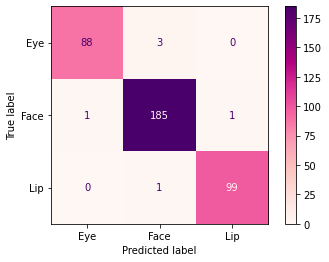

In [182]:
matrix = confusion_matrix(y_test, y_pred, labels = gs_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels= gs_clf.classes_)
disp.plot(cmap='RdPu')

Confusion matrix is also the same. It is likely no further improvement can be made on this model.